In [1]:
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np



from datetime import date, timedelta, datetime
from time import sleep
import os.path

import re
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sentimenter import sentimenter as slr

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, LassoCV
# from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

from sklearn.externals import joblib

import pydot
from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/home/ali/Anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ali/Anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Data Collection

In [3]:
companies = slr.get_companies()
companies['Ticker_symbol'] = companies['Ticker_symbol'].apply(lambda x: x.replace('.N', ''))
print companies.info()
companies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 504
Data columns (total 8 columns):
Ticker_symbol              505 non-null object
Security                   505 non-null object
SEC_filings                505 non-null object
GICS_Sector                505 non-null object
GICS_Sub_Industry          505 non-null object
Address_of_Headquarters    505 non-null object
Date_first_added           305 non-null object
CIK                        505 non-null int64
dtypes: int64(1), object(7)
memory usage: 35.5+ KB
None


,Ticker_symbol,Security,SEC_filings,GICS_Sector,GICS_Sub_Industry,Address_of_Headquarters,Date_first_added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [56]:
all_articles = slr.get_sentimentalized_articles(companies)
all_articles.info()

['RIG', 'TRIP', 'FOXA', 'FOX', 'TSN', 'UDR', 'ULTA', 'USB', 'UA', 'UA.C', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'URBN', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WFC', 'HCN', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WFM', 'WMB', 'WLTW', 'WEC', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']
(66421, 6) (66192, 10)
need to sentimentalize 3 symbols
updated sentiments
<class 'pandas.core.frame.DataFrame'>
Int64Index: 66354 entries, 0 to 161
Data columns (total 10 columns):
Article     66354 non-null object
Date        66354 non-null object
Symbol      66354 non-null object
Time        66354 non-null object
Title       66354 non-null object
Url         66354 non-null object
compound    66354 non-null float64
neg         66354 non-null float64
neu         66354 non-null float64
pos         66354 non-null float64
dtypes: float64(4), object(6)
memory usage: 5.6+ MB


In [57]:
quotes = slr.update_quotes(all_articles)
quotes.info()

Available symbol quotes:  440
New downloaded symbol quotes:  3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325003 entries, 0 to 325002
Data columns (total 8 columns):
Date         325003 non-null object
Adj Close    310519 non-null float64
Close        325003 non-null float64
High         325003 non-null float64
Low          325003 non-null float64
Open         325003 non-null float64
Symbol       325003 non-null object
Volume       325003 non-null float64
dtypes: float64(6), object(2)
memory usage: 19.8+ MB


# Data preparation

In [6]:
# Change Time column to simple time format
all_articles.Time = all_articles.Time.apply(lambda x: re.search('[0-9]?[0-9]:[0-9]{1,2}', x).group(0))
# Convert Date to DateTime
all_articles['Date'] = pd.to_datetime(all_articles['Date'], format='%Y-%m-%d')
all_articles.head()

,Article,Date,Symbol,Time,Title,Url,compound,neg,neu,pos
0,MOSCOW Jan 17 Russia's biggest home electron...,2014-01-17,MMM,7:49,Russia's M.video says consumer confidence weak...,http://www.reuters.com//article/russia-mvideo-...,0.0516,0.049,0.901,0.051
1,By Lewis Krauskopf Diversified manufacture...,2014-01-30,MMM,9:44,"3M revenue growth slows, misses Wall Street ta...",http://www.reuters.com//article/us-3m-results-...,0.7096,0.037,0.896,0.067
2,By Lewis KrauskopfJan 30 Diversified manufac...,2014-01-30,MMM,9:42,"UPDATE 2-3M revenue growth slows, misses Wall ...",http://www.reuters.com//article/3m-results-idU...,0.7964,0.038,0.886,0.076
3,Jan 30 Diversified manufacturer 3M Co poste...,2014-01-30,MMM,7:39,Manufacturer 3M posts 11 percent rise in net i...,http://www.reuters.com//article/3m-results-idU...,0.7430,0.000,0.885,0.115
4,3M Co. has invested US$15 million in one of ...,2014-03-10,MMM,8:19,SINGAPORE PRESS-3M to lift N95 mask output at ...,http://www.reuters.com//article/singapore-pres...,0.4019,0.000,0.958,0.042


In [7]:
# Remove unwanted column
quotes = quotes.drop('Adj Close', axis=1)
# Convert Date to DateTime
quotes['Date'] = pd.to_datetime(quotes['Date'], format='%Y-%m-%d')
quotes.head()

,Date,Close,High,Low,Open,Symbol,Volume
0,2014-01-02,35.53,36.11,35.47,36.05,AEE,1394264.0
1,2014-01-03,35.40,35.69,35.22,35.63,AEE,1206534.0
2,2014-01-06,35.76,35.82,35.42,35.70,AEE,2837469.0
3,2014-01-07,36.22,36.25,35.81,35.81,AEE,1653721.0
4,2014-01-08,35.94,36.19,35.80,36.14,AEE,1618538.0


In [8]:
articles = all_articles.copy()
# create a new dataframe with just sentiments
articles = articles[['Date', 'Symbol', 'compound', 'neg', 'neu', 'pos']]

In [9]:
# pivot multiple news to a single one by averaging its score
articles = pd.pivot_table(articles,
                          index=['Date', 'Symbol'],
                          values=['compound', 'neg', 'neu', 'pos'],
                          aggfunc=np.average).reset_index()
articles.head()

,Date,Symbol,compound,neg,neu,pos
0,2014-01-01,AAL,0.97710,0.035000,0.897,0.068000
1,2014-01-01,AZO,0.99110,0.055000,0.836,0.109000
2,2014-01-01,BRKB,-0.99340,0.122000,0.822,0.056000
3,2014-01-01,CPB,-0.17790,0.079500,0.864,0.056000
4,2014-01-02,AAPL,0.95785,0.031833,0.876,0.092333


In [10]:
# check whether we have news and quotes for same number of symbols
print "We have {} symbols in articles and {} symbols in quotes".format(
    len(articles['Symbol'].unique()), len(quotes['Symbol'].unique()))
print "shape of articles: {}, shape of quotes: {}".format(articles.shape, quotes.shape)

We have 440 symbols in articles and 440 symbols in quotes
shape of articles: (26616, 6), shape of quotes: (322768, 7)


In [11]:
# join articles to quotes
quotes_articles = quotes.set_index(['Date', 'Symbol']).join(
    articles.set_index(['Date', 'Symbol']), rsuffix='r').reset_index()
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN


In [12]:
quotes_articles['Next_Close'] = quotes_articles['Close'].shift(-1) # used fo calculating next day's slope
quotes_articles['Next_Open'] = quotes_articles['Open'].shift(-1)   # for some possible prediction
quotes_articles['Prev_Close'] = quotes_articles['Close'].shift(1)  # used fo calculating previous day's slope
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN,35.40,35.63,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN,35.76,35.70,35.53
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN,36.22,35.81,35.40
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN,35.94,36.14,35.76
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN,36.04,36.02,36.22


In [13]:
# Since we did shift on the whole document we need to change first and last quote for each symbol
for symbol in quotes_articles['Symbol'].unique():
    min_date = quotes_articles[(quotes_articles['Symbol'] == symbol)].Date.min()
    max_date = quotes_articles[(quotes_articles['Symbol'] == symbol)].Date.max()
    quotes_articles.Prev_Close[(quotes_articles['Symbol'] == symbol) & (quotes_articles['Date'] == min_date)] = None
    quotes_articles.Prev_Close[(quotes_articles['Symbol'] == symbol) & (quotes_articles['Date'] == max_date)] = None
quotes_articles.head()

/home/ali/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ali/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN,35.40,35.63,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN,35.76,35.70,35.53
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN,36.22,35.81,35.40
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN,35.94,36.14,35.76
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN,36.04,36.02,36.22


In [14]:
calculate_slopes = lambda x: pd.Series([
        x['Close'] - x['Prev_Close'],
        x['Next_Close'] - x['Close'],
        (x['Next_Close'] - x['Close']) - (x['Close'] - x['Prev_Close']),
    ])

In [15]:
tmp = quotes_articles.apply(calculate_slopes, axis=1)
tmp.columns = ['Prev_Slope', 'Next_Slope', 'Diff_Slope']
quotes_articles = pd.concat([quotes_articles, tmp], axis=1)

In [16]:
# simple select for quotes with articles
has_news = quotes_articles[(quotes_articles['compound'].notnull())]
has_news = has_news.dropna()
has_news.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close,Prev_Slope,Next_Slope,Diff_Slope
355,2015-06-02,AEE,39.62,40.01,39.26,40.00,1481676.0,-0.033950,0.0545,0.924000,0.021500,39.31,39.51,40.22,-0.60,-0.31,0.29
390,2015-07-22,AEE,38.66,39.04,38.61,38.73,1354719.0,-0.979000,0.0910,0.892000,0.017000,38.27,38.55,38.70,-0.04,-0.39,-0.35
432,2015-09-21,AEE,40.82,41.06,40.39,40.52,1704133.0,-0.599400,0.0580,0.919000,0.024000,40.50,40.52,40.37,0.45,-0.32,-0.77
570,2016-04-08,AEE,48.78,51.00,48.70,49.40,4807348.0,0.839033,0.0000,0.872333,0.127667,48.68,48.86,49.16,-0.38,-0.10,0.28
592,2016-05-10,AEE,48.66,48.86,48.40,48.52,1366599.0,0.778300,0.0000,0.833000,0.167000,48.15,48.63,48.43,0.23,-0.51,-0.74


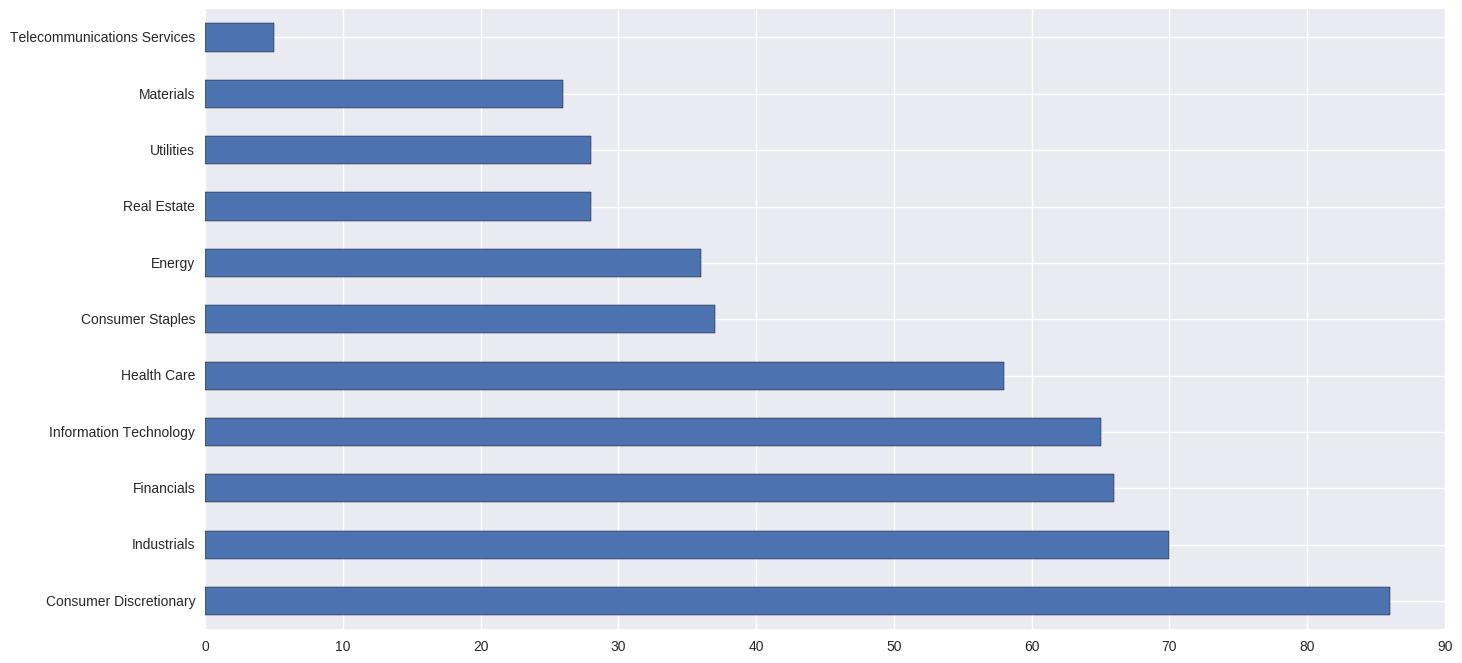

In [17]:
companies.GICS_Sector.value_counts().plot.barh(figsize=(16, 8))

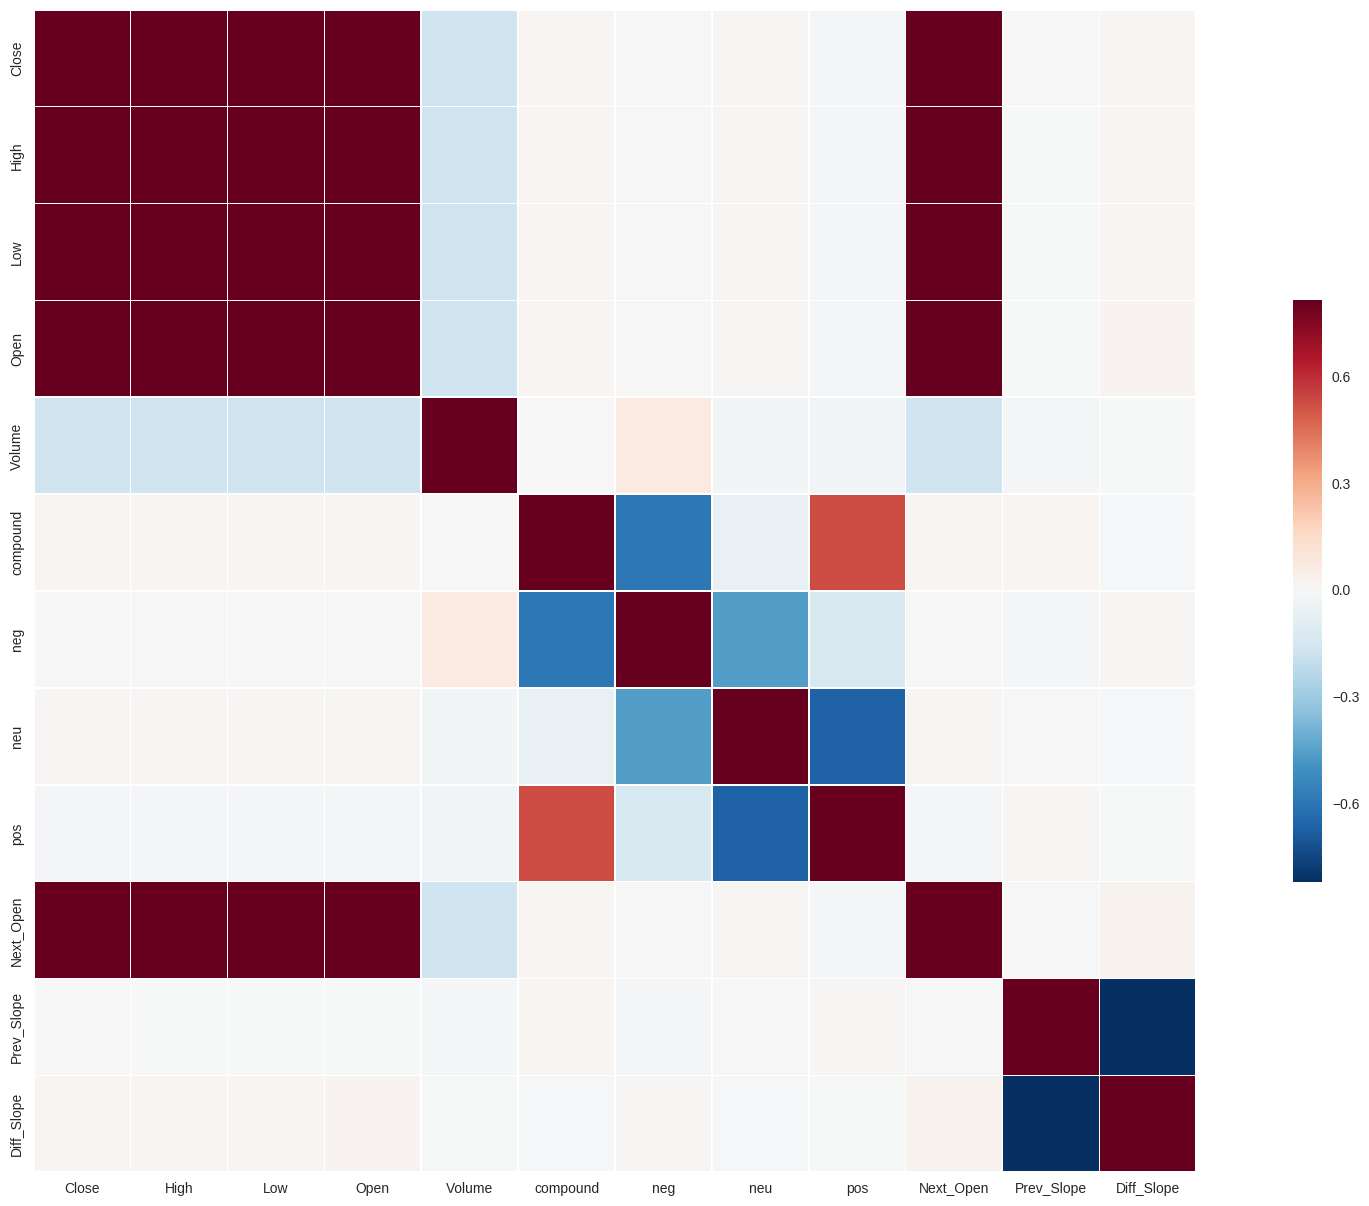

In [18]:
plt.figure(figsize=(25,15))
sns.heatmap(
    has_news[['Close', 'High', 'Low', 'Open', 'Volume',
              'compound', 'neg', 'neu', 'pos', 'Next_Open',
              'Prev_Slope', 'Diff_Slope']].corr(),
    vmax=.3,
    square=True, 
    linewidths=.5,
    cbar_kws={"shrink": .5})

In [40]:
x = has_news[['Close', 'High', 'Low', 'Open', 'Volume', 'compound',
              'neg', 'neu', 'pos', 'Next_Open', 'Prev_Slope']]
y = has_news['Diff_Slope']
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3)

# Modeling

In [41]:
def CV(target):
    return StratifiedKFold(target, n_folds=3,
                           shuffle=True, random_state=41)


def grid_search(model, params, cv):
    return GridSearchCV(estimator=model, 
                    param_grid=params,
                    cv=cv
                   )

def regression_results(model, x_true, y_true, y_pred):
    ret = ("Explained variance regression score:  {}\n".format(
            explained_variance_score(y_true, y_pred, multioutput='uniform_average')))
    ret += ("Mean Absolute Error:                  {}\n".format(
            mean_absolute_error(y_true, y_pred)))
    ret += ("Model socre is:                       {}\n".format(
            model.score(x_true, y_true)))
    return ret


def draw_feature_importance(model, data):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    feature_names = data.columns
    # Plot the feature importances of the model
    plt.figure(figsize=(20,15))
    plt.title("Feature importances")
    plt.bar(range(data.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(data.shape[1]), feature_names[indices], rotation=90)
    plt.xlim([-1, data.shape[1]])
    return plt


def model_test_metrics(model, data, target):
    ret = "Test Data score: ", model.fit(data, target).score(data, target)
    return ret + regression_results(target, model.predict(data))


def evaluate_model(model, data, target, params=None, draw_features=True, verbose=True):
    train_data, test_data, train_target, test_target=train_test_split(data, target)
#     cv=CV(train_target)
    cv = 3
    ret = ""
    if params:
        grid=grid_search(model, params, cv)
    
        grid.fit(train_data, train_target)
        model = grid.best_estimator_
        ret += ("Best Model after Grid Search:\n{}\n\n").format(model)        
    else:
        model.fit(train_data, train_target)
        ret += "Model:\n{}\n\n".format(model)
        
    s=cross_val_score(model, train_data, train_target, cv=cv, n_jobs=-1)
    if verbose:
        ret += ("Mean score of the model is:           {}\n").format(s.mean())
        predictions = model.predict(test_data)
        ret += regression_results(model, test_data, test_target, predictions)

    if draw_features:
        draw_feature_importance(model, train_data)
    return model, ret

In [42]:
def linear_regression(data, target):
    params = {
        'fit_intercept': [False, True]
    }
    return evaluate_model(LinearRegression(n_jobs=-1),
                          data, target,
                          draw_features=False,
                          params=params)

def ridge_cv(data, target):
    return evaluate_model(
        RidgeCV(alphas=[0.1, .5, 1.0, 5.0, 10.0, 100.0],normalize=True),
        data, target, draw_features=False)

def random_forest(data, target, draw_features=False):
    params = {
        'n_estimators': [10, 20, 50, 100, 200],
        'max_depth': [1, 2, 3, 4, 5],
        'min_samples_split': [2, 10, 25, 50, 100],
    #     'min_samples_leaf': [1, 2, 3, 4, 5, 10]
    }
    return evaluate_model(RandomForestRegressor(n_jobs=-1),
                          data, target,
                          params=params, draw_features=draw_features)

def extra_trees(data, target, draw_features=False):
    params = {
        'n_estimators': [10, 20, 50, 100, 200],
        'max_depth': [1, 2, 3, 4, 5],
        'min_samples_split': [2, 10, 25, 50, 100],
    }
    return evaluate_model(ExtraTreesRegressor(n_jobs=-1),
                          data, target,
                          params=params, draw_features=draw_features)

In [43]:
lr, lr_report = linear_regression(x_train, y_train)

In [44]:
print lr_report
print "score for test data is: {}".format(lr.score(x_test, y_test))

Best Model after Grid Search:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Mean score of the model is:           0.892748764349
Explained variance regression score:  0.784013347421
Mean Absolute Error:                  1.12465842669
Model socre is:                       0.783931622306

score for test data is: 0.942999474005


In [45]:
rd, rd_report = ridge_cv(x_train, y_train)

In [46]:
print rd_report
print "score for test data is: {}".format(rd.score(x_test, y_test))

Model:
RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100.0], cv=None, fit_intercept=True,
    gcv_mode=None, normalize=True, scoring=None, store_cv_values=False)

Mean score of the model is:           0.657858804505
Explained variance regression score:  0.194009680375
Mean Absolute Error:                  1.66443854486
Model socre is:                       0.193765049079

score for test data is: 0.872213497674


In [47]:
rf, rf_report = random_forest(x_train, y_train)

In [48]:
print rf_report
print "score for test data is: {}".format(rf.score(x_test, y_test))

Best Model after Grid Search:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Mean score of the model is:           0.473690692161
Explained variance regression score:  0.104975604664
Mean Absolute Error:                  1.65838995649
Model socre is:                       0.104873989508

score for test data is: 0.759054636423


In [49]:
et, et_report = extra_trees(x_train, y_train)

In [50]:
print et_report
print "score for test data is: {}".format(et.score(x_test, y_test))

Best Model after Grid Search:
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=5,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=25, min_weight_fraction_leaf=0.0,
          n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

Mean score of the model is:           0.259287380754
Explained variance regression score:  0.515636866569
Mean Absolute Error:                  1.79192442225
Model socre is:                       0.515113548189

score for test data is: 0.827422539172


In [51]:
def plot_predicted_measured(ax, y_real, predictions, fontsize=24, title=''):
    ax.scatter(y_real, predictions)
    ax.plot([predictions.min(), predictions.max()], [predictions.min(), predictions.max()], 'k--', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(title, fontsize=fontsize)


def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])

    
def plot_comparisions(y_real, y_lr, y_rd, y_rf, y_et):
    set_style()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(12)
    fig.set_figwidth(12)
    plot_predicted_measured(ax1, y_real, y_lr, fontsize=16, title='Linear Regression')
    plot_predicted_measured(ax2, y_real, y_rd, fontsize=16, title='RidgeCV')
    plot_predicted_measured(ax3, y_real, y_rf, fontsize=16, title='Random Forest')
    plot_predicted_measured(ax4, y_real, y_et, fontsize=16, title='Extra Trees')

    plt.show()

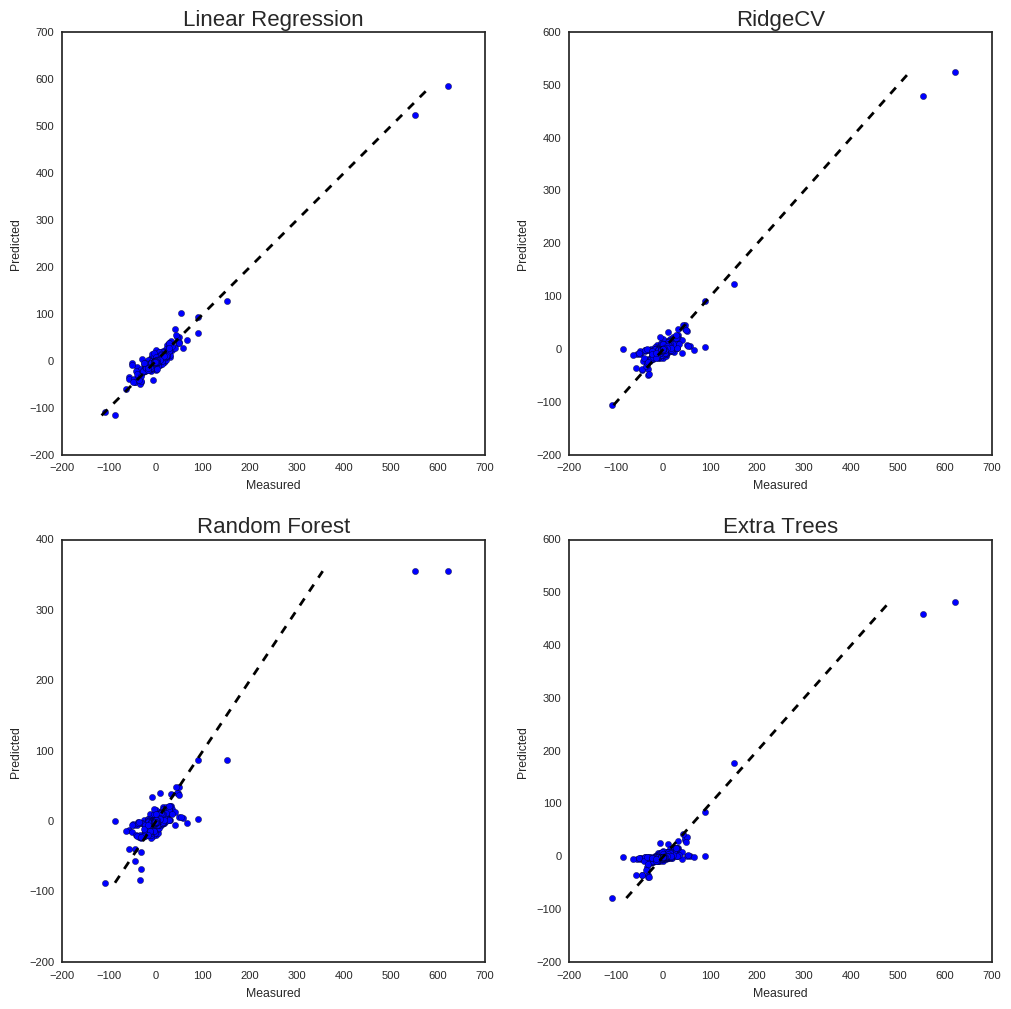

In [52]:
plot_comparisions(y_test,
                  lr.predict(x_test),
                  rd.predict(x_test),
                  rf.predict(x_test),
                  et.predict(x_test)
                 )

In [53]:
sector_symbols = {}
for sector in companies.GICS_Sector.unique():
    sector_symbols[sector] = list(companies.Ticker_symbol[companies.GICS_Sector == sector])

(206, 11) (206,)


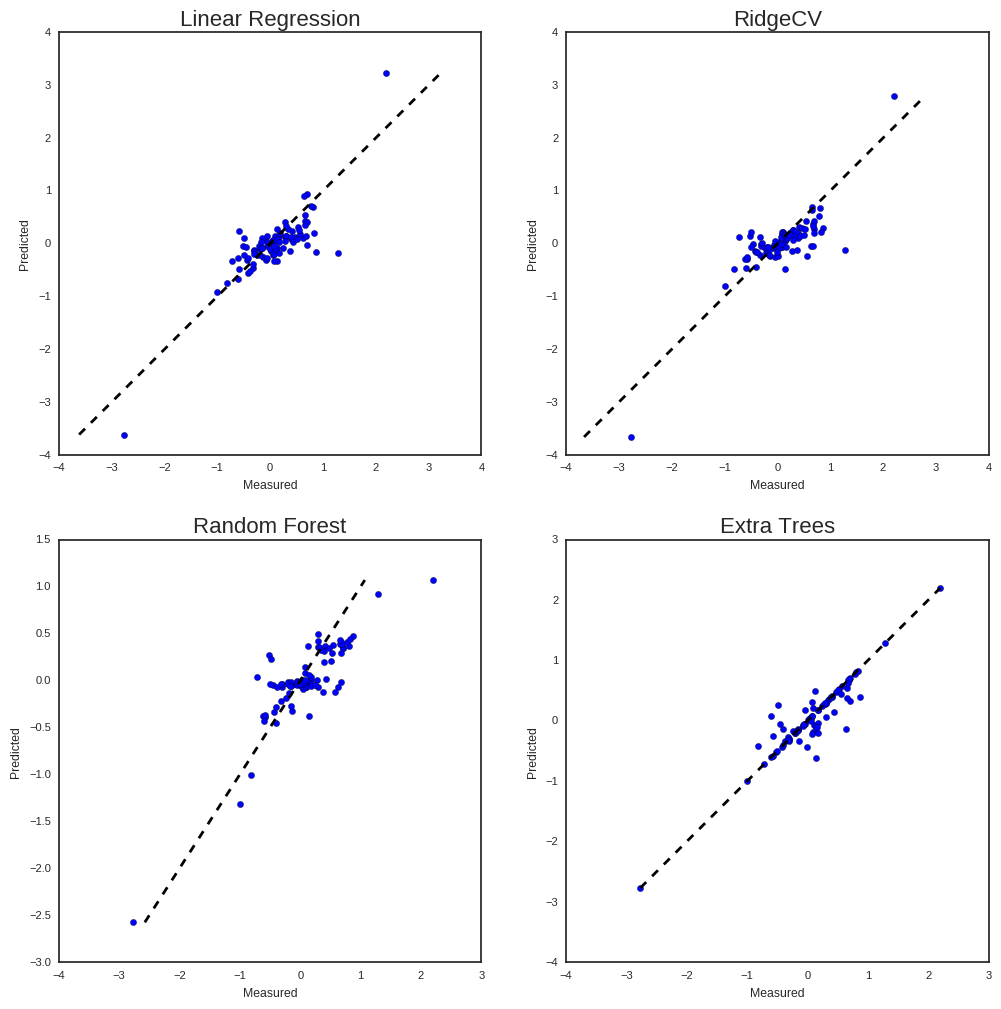

(2070, 11) (2070,)


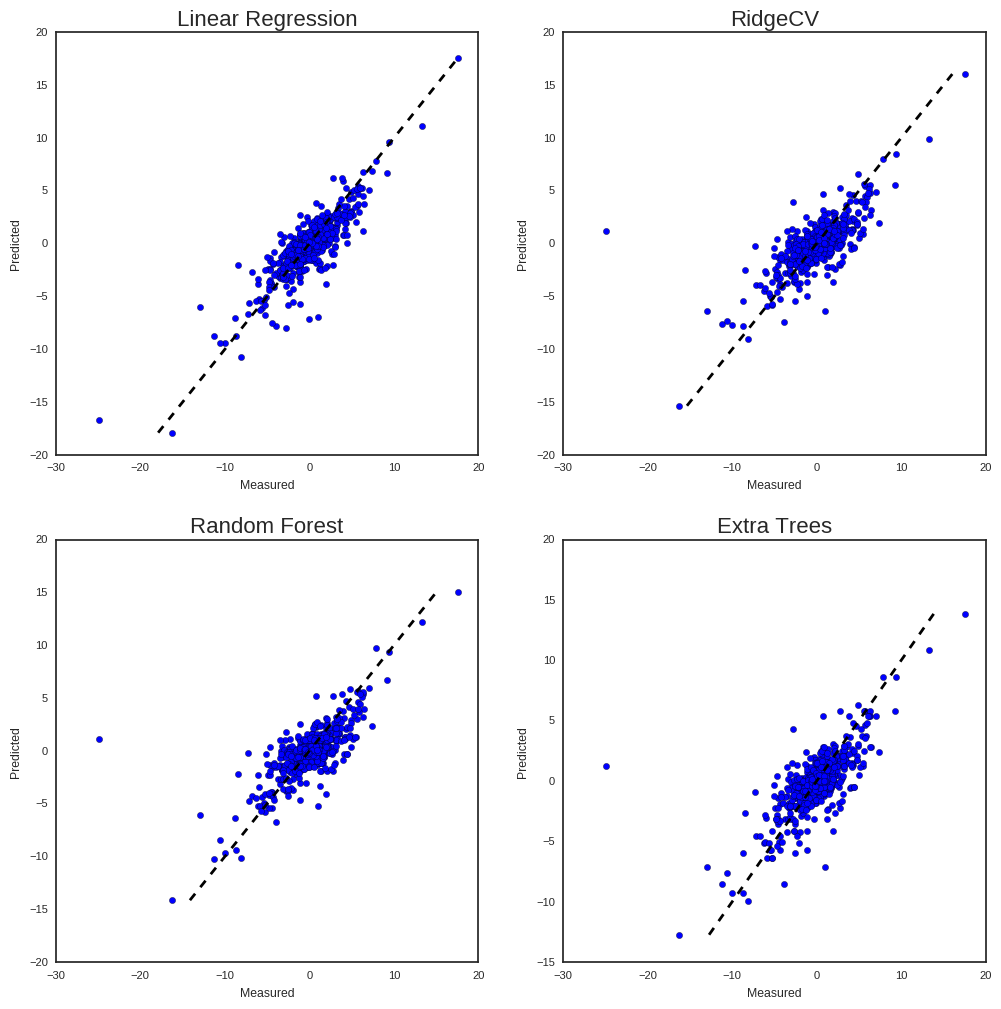

(3155, 11) (3155,)


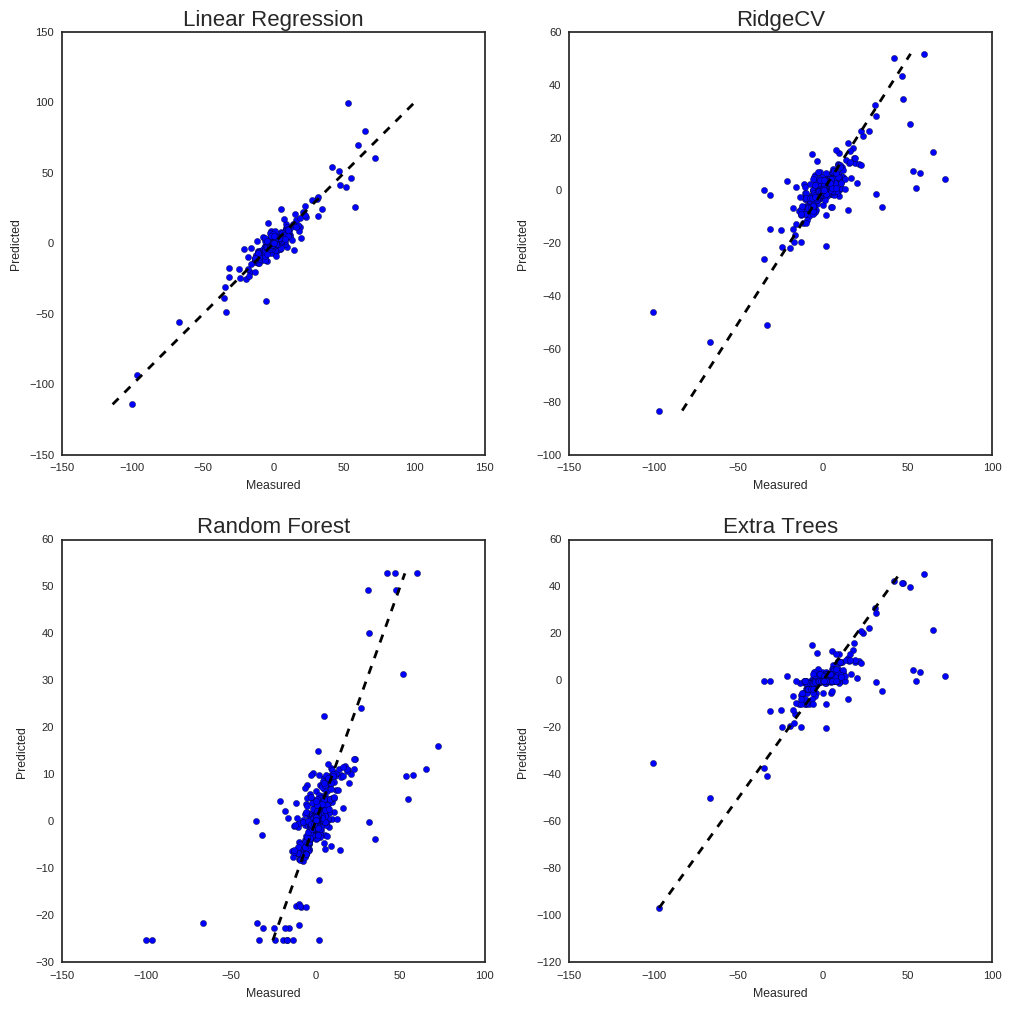

(354, 11) (354,)


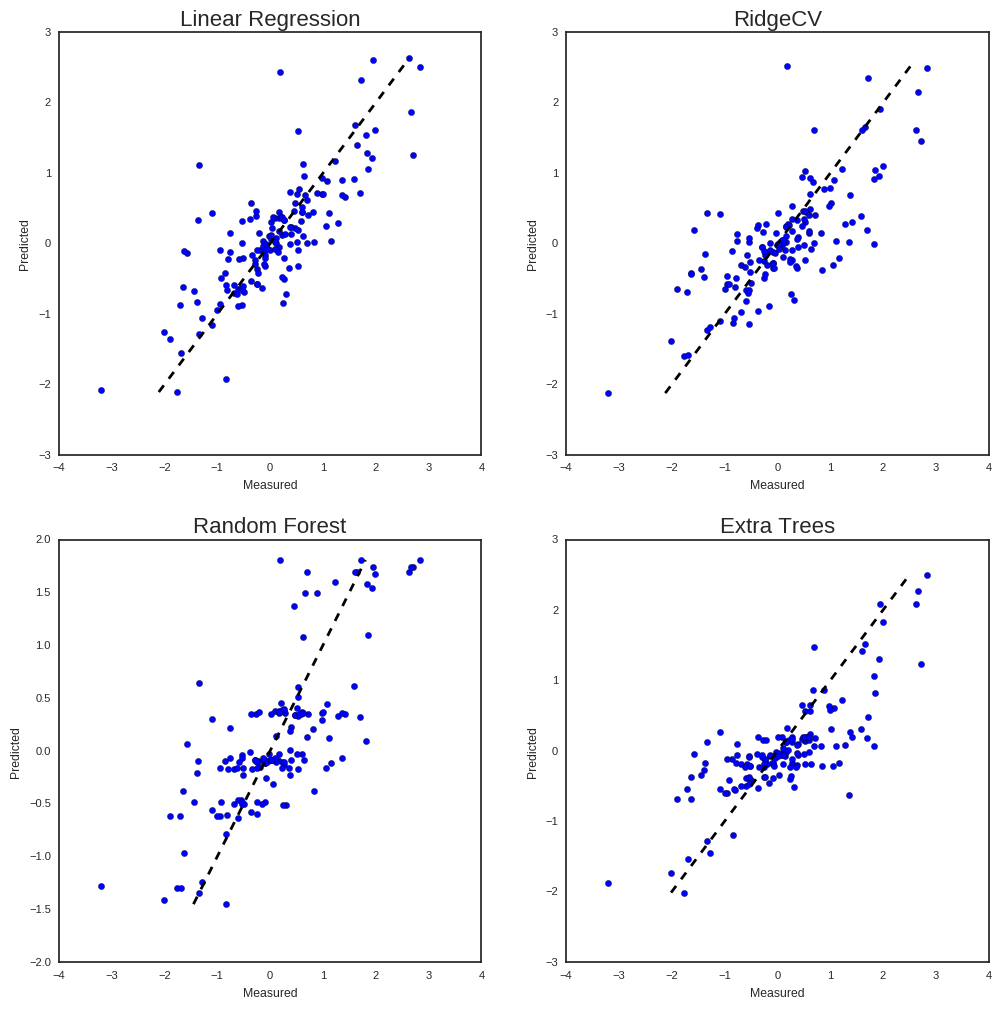

(1133, 11) (1133,)


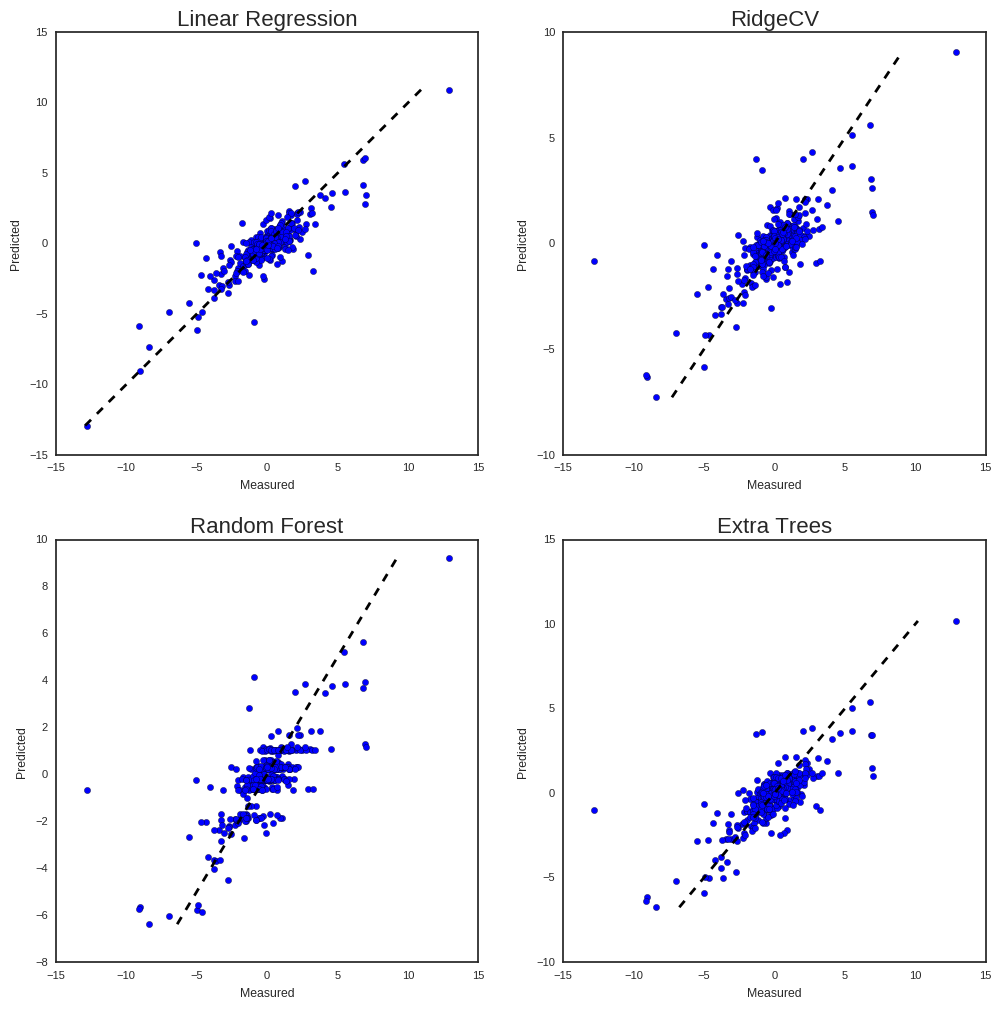

(2209, 11) (2209,)


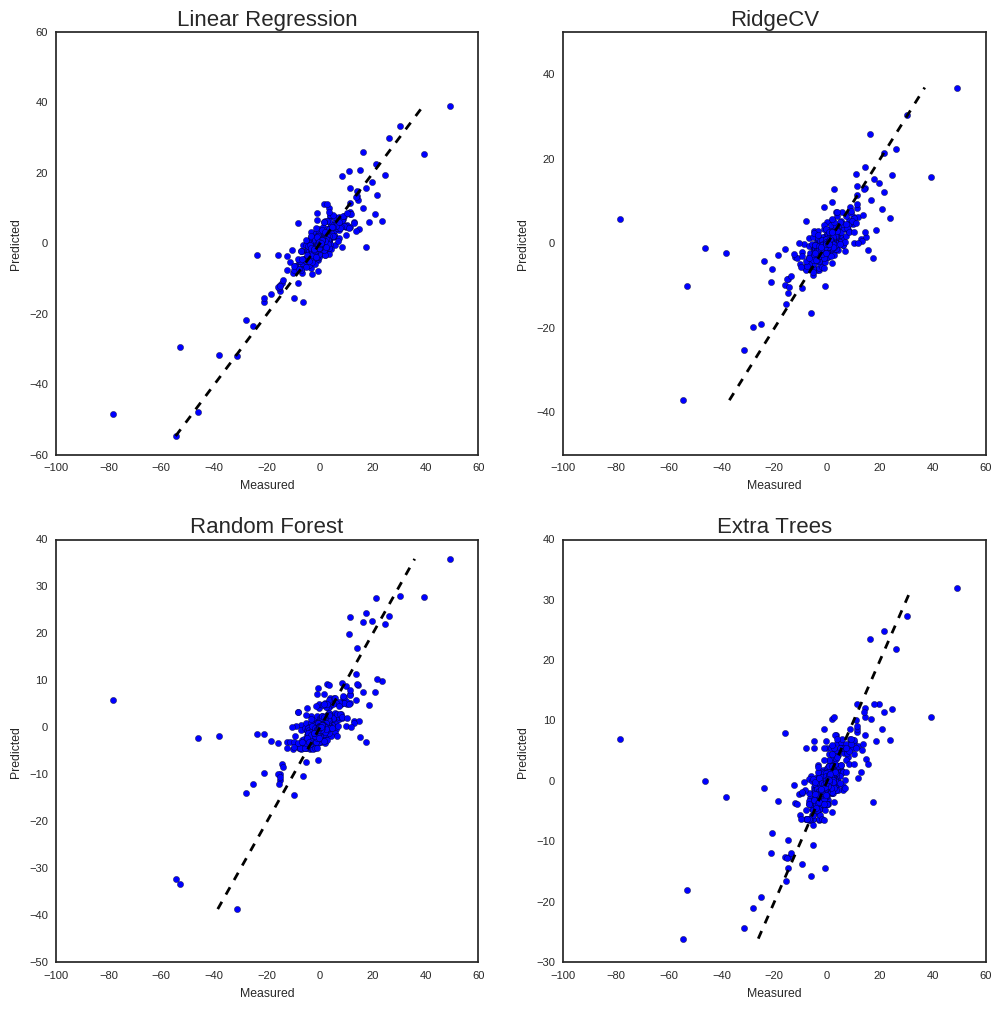

(737, 11) (737,)


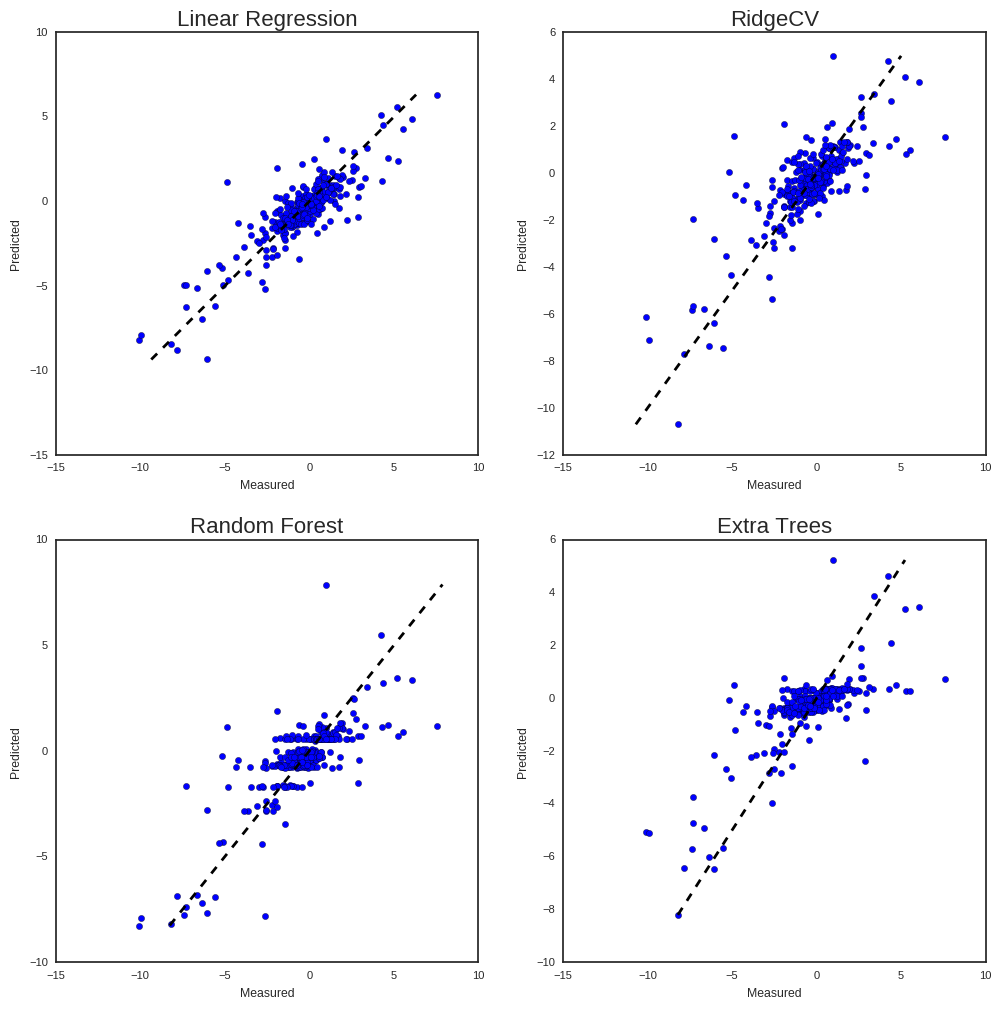

(3292, 11) (3292,)


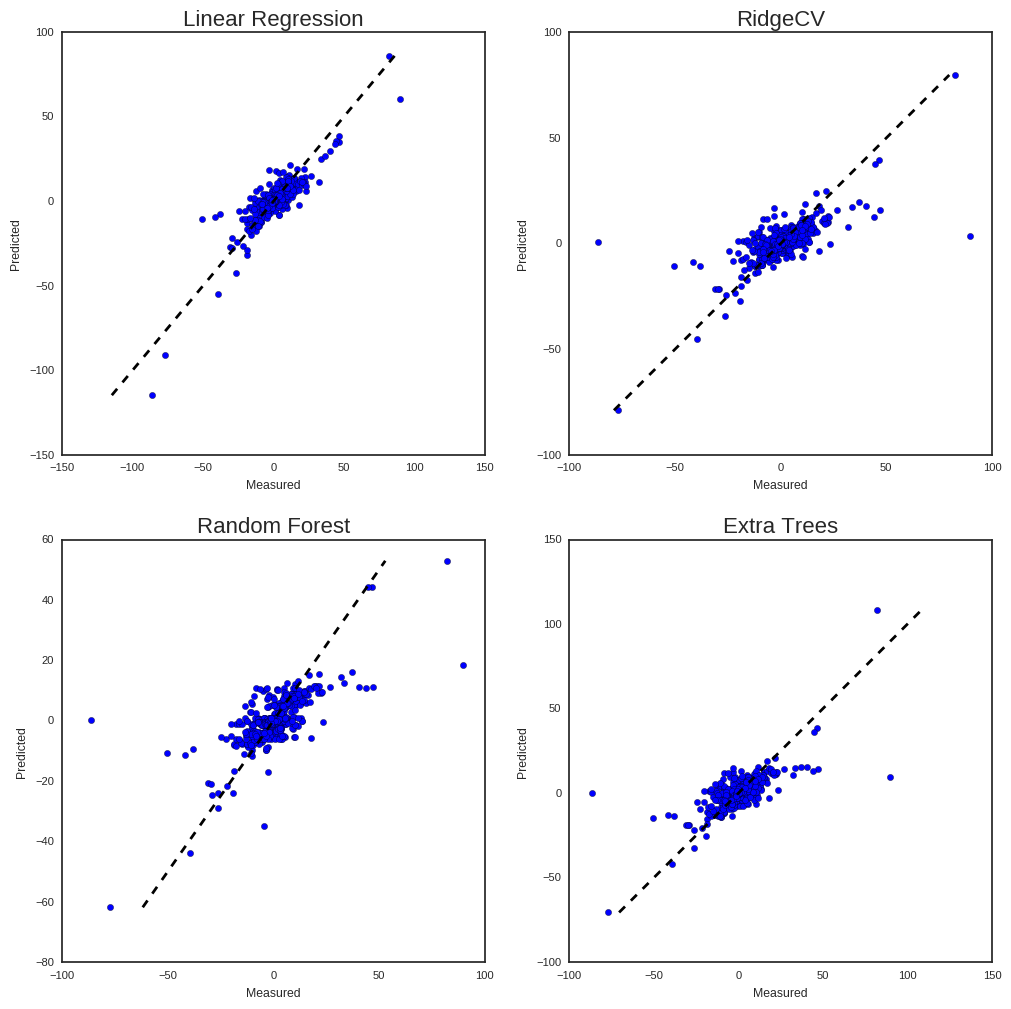

(212, 11) (212,)


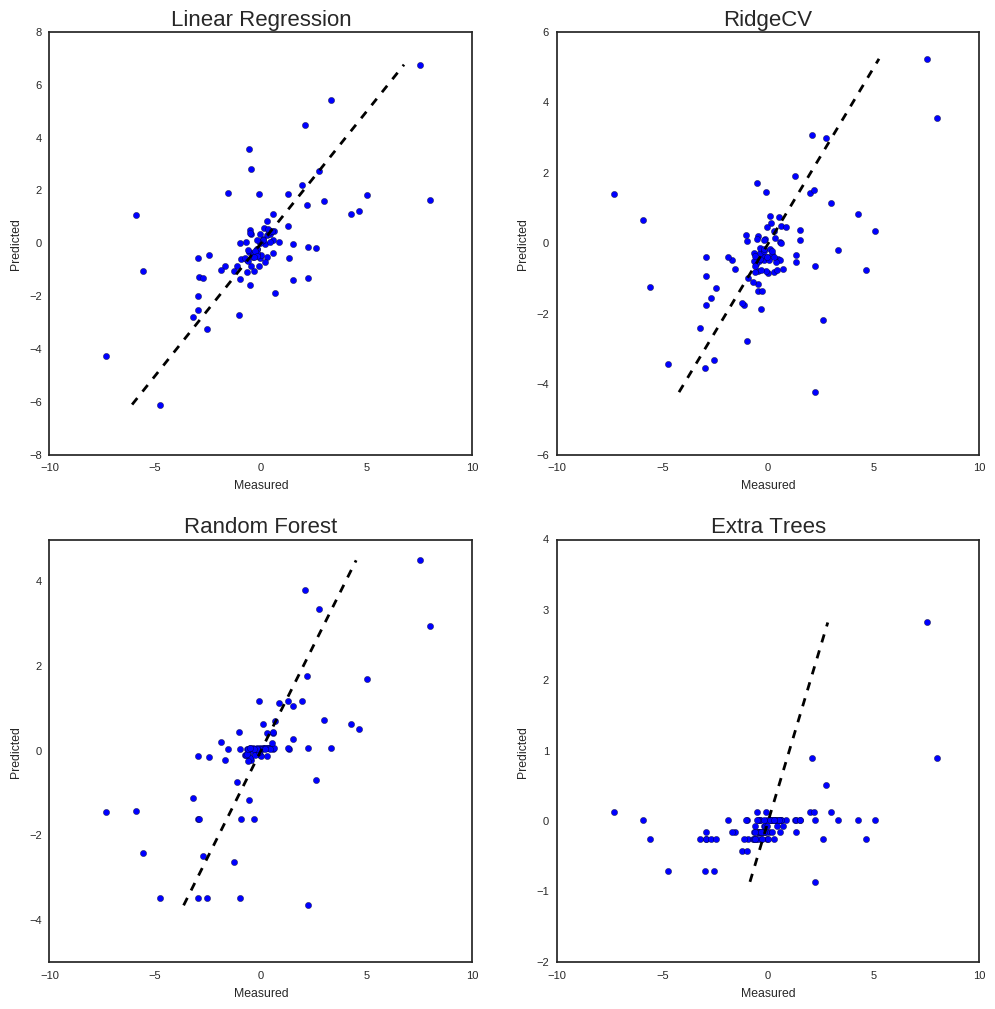

(1488, 11) (1488,)


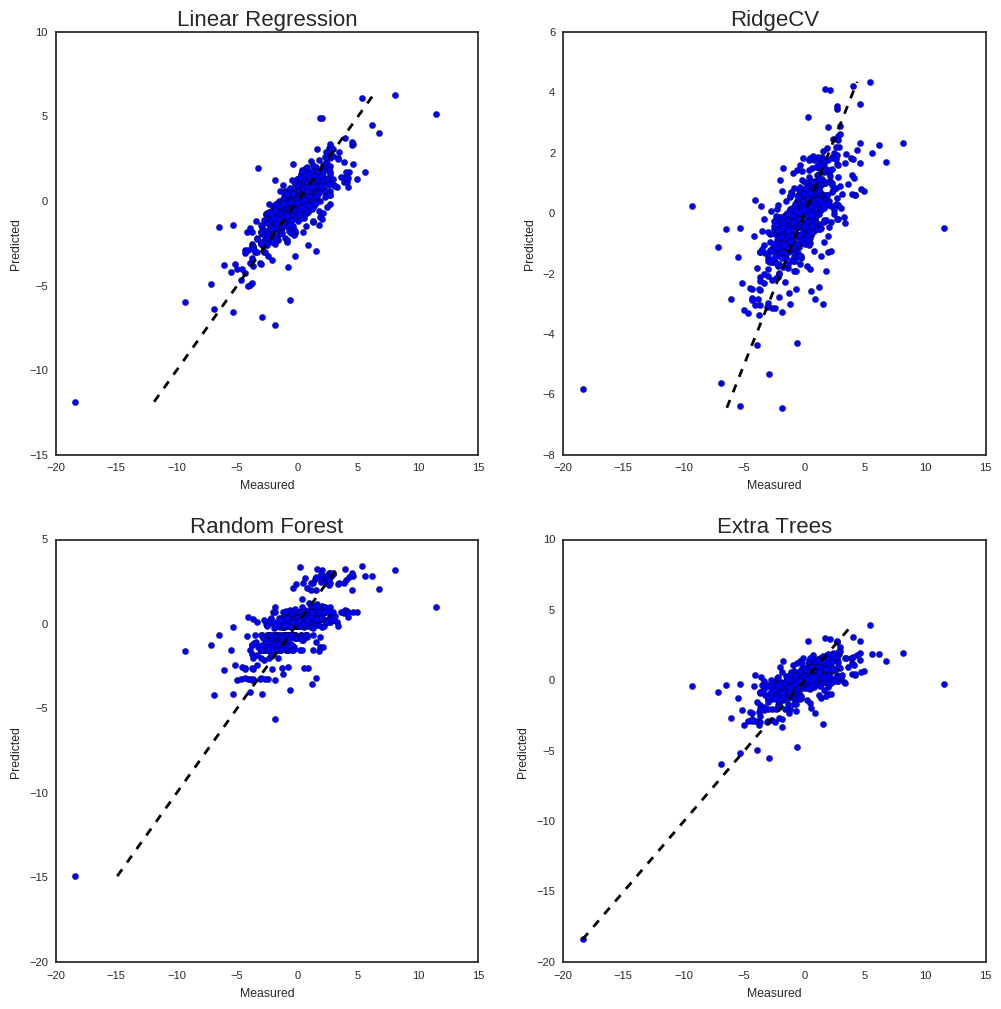

(2753, 11) (2753,)


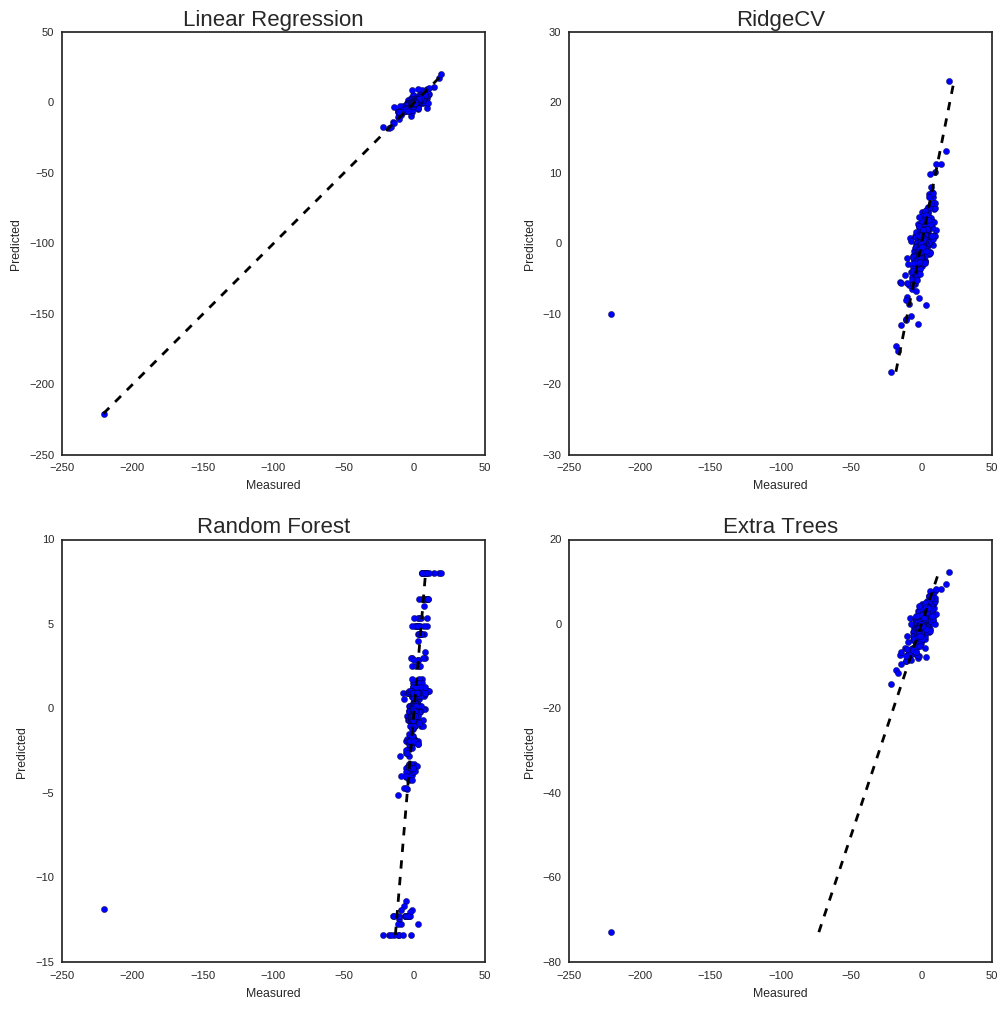

In [55]:
for sector, symbols in sector_symbols.iteritems():
    sector_news = has_news[(has_news.Symbol.isin(sector_symbols[sector]))]

    sec_x = sector_news[['Close', 'High', 'Low', 'Open', 'Volume', 'compound',
                         'neg', 'neu', 'pos', 'Next_Open', 'Prev_Slope']]
    sec_y = sector_news['Diff_Slope']
    sec_x_train, sec_x_test, sec_y_train, sec_y_test=train_test_split(sec_x, sec_y, test_size=0.3)
    print sec_x_train.shape, sec_y_train.shape

    filename = 'datasets/models/{}.sav'.format(sector.replace(' ', '_'))

    sec_dic = {}
    if os.path.exists(filename):
        sec_dic = joblib.load(filename)
    else:
        sec_dic['lr_model'], sec_dic['lr_report'] = linear_regression(sec_x_train, sec_y_train)
        sec_dic['rd_model'], sec_dic['rd_report'] = ridge_cv(sec_x_train, sec_y_train)
        sec_dic['rf_model'], sec_dic['rf_report'] = random_forest(sec_x_train, sec_y_train)
        sec_dic['et_model'], sec_dic['et_report'] = extra_trees(sec_x_train, sec_y_train)
        
        joblib.dump(sec_dic, filename)
    
#     print print_comparisions(sec_y_test, sec_x_test,
#                              sec_dic['lr_model'],
#                              sec_dic['rd_model'],
#                              sec_dic['rf_model'],
#                              sec_dic['et_model'],
#                              title = sector
#                      )
    plot_comparisions(sec_y_test,
                      sec_dic['lr_model'].predict(sec_x_test),
                      sec_dic['rd_model'].predict(sec_x_test),
                      sec_dic['rf_model'].predict(sec_x_test),
                      sec_dic['et_model'].predict(sec_x_test)
                     )